# Density Estimation with Gaussian Mixture Models (GMMs)

Consider a case where you wish to fit a distribution to a set of data points. Because many real-world data sets are multi-modal, common distributions such as a gaussian or a beta distribution wouldn't suffice. One approach is to use these more common distribution models as primitives and *mix* them, assigning each primitive a specific weight to describe the data-generating distribution. Here, we consider the specific case of modeling using gaussian primitives, the corresponding model is called a Gaussian Mixture Model (GMM)

$$p(\mathbf{x})=\sum_{k=1}^{K}\pi_k\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_k,\Sigma_k).$$

### Background

To understand how to fit this distribution to our data, let's start by considering a single component,

$$p(\mathbf{x}\;|\;z_{k}=1)=\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_k, \Sigma_k)$$

where $\mathbf{x}$ represents a data point drawn from the data-generating distribution, $z_k$ is a latent binary indicator variable representing whether or not $\mathbf{x}$ is drawn from the $k$th component of the mixture model, $\mathbf{\mu}_k$ is the mean of the $k$th component, and $\Sigma_k$ is the covariance of the $k$th component. We define the prior over the latent variable $\mathbf{z}$ as

$$p(\mathbf{z})=\mathbf{\pi}=[\pi_1,...,\pi_K]^T,\quad \sum_{k=1}^{K}\pi_k=1$$

where $p(z_k=1)=\pi_k$ is the probability of an arbitrary data point $\mathbf{x}$ being drawn from the $k$th component of the mixture distribution. Additionally, the joint distribution is defined as

$$p(\mathbf{x},\mathbf{z})=  \begin{bmatrix}
 p(\mathbf{x},z_1=1)  \\
 ...  \\
 p(\mathbf{x},z_K=1)  \\
\end{bmatrix} =  \begin{bmatrix}
 \pi_1\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_1,\Sigma_1)  \\
 ...  \\
 \pi_K\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_K,\Sigma_K)  \\
\end{bmatrix}.$$

From the above, we can construct the posterior distribution over for a single example

$$p(z_k=1\;|\;\mathbf{x})=\frac{p(\mathbf{x}\;|\;z_k=1)p(z_k=1)}{p(\mathbf{x})}=\frac{\pi_k\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_k, \Sigma_k)}{\sum_{k=1}^{K}\pi_k\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_k,\Sigma_k)}.$$

Consider the posterior over the whole dataset $\mathcal{X}$

$$p(z_{nk}=1\;|\;\mathbf{x}_n)=\frac{p(\mathbf{x_n}\;|\;z_{nk}=1)p(z_{nk}=1)}{\sum_{j=1}^{K}p(\mathbf{x_n}\;|\;z_{nj}=1)p(z_{nj}=1)}$$

$$=\frac{\pi_k\mathcal{N}(\mathbf{x}_n\;|\;\mathbf{\mu}_k,\Sigma_k)}{\sum_{j=1}^{K}\pi_j\mathcal{N}(\mathbf{x}_n\;|\;\mathbf{\mu}_j,\Sigma_j)}$$

$$=r_{nk}.$$

We call $r_{nk}$ the *responsibility* of mixture component $k$ for datapoint $n$.

### Maximum Likelihood Estimation

Since the ultimate goal here is *fitting* the distribution to the data, let us also formally define our model parameters and how they relate to the data and the latent variables. We can express the data distribution conditioned on the parameters, $\mathbf{\theta}:=\{\mathbf{\mu}_k,\Sigma_k,\pi_k\;|\;k=1,...,K\}$, by marginalizing out $\mathbf{z}$

$$p(\mathbf{x}\;|\;\mathbf{\theta})=\sum_z p(\mathbf{x}\;|\;\mathbf{\theta},\mathbf{z})p(\mathbf{z}\;|\;\mathbf{\theta})$$

$$=\sum_{k=1}^K p(\mathbf{x}\;|\;\mathbf{\theta},z_k=1)p(z_k=1\;|\;\mathbf{\theta})$$

$$=\sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_k, \Sigma_k).$$

Consequently, the likelihood can be expressed as

$$p(\mathcal{X}\;|\;\mathbf{\theta})=\prod_{n=1}^{N}p(\mathbf{x}_n\;|\;\mathbf{\theta})=\prod_{n=1}^{N}\sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}\;|\;\mathbf{\mu}_k, \Sigma_k).$$

Our ultimate goal here is to find the parameters that maximize the likelihood... at least locally. The update equations are given below. We have to resort to an iterative solution via the expectation maximization (EM) algorithm to find a local optimum for the maximum likelihood estimation since a closed form solution doesn't exist (the solutions derived via maximizing the log-likelihood rely on $r_{nk}$ which depends on parameter values from previous iterations). In the E-step, we compute $r_{nk}$ values and in the M-step, we compute the following

$$\mu_k^{new}=\frac{\sum_{n=1}^Nr_{nk}\mathbf{x}_n}{N_k}$$

$$\Sigma_k^{new}=\frac{\sum_{n=1}^Nr_{nk}(\mathbf{x}_n-\mathbf{\mu}_k^{new})(\mathbf{x}_n-\mathbf{\mu}_k^{new})^T}{N_k}$$

$$\pi_k^{new}=\frac{N_k}{N}$$

where $N_k$ is the *total responsibility* of componenent $k$ which is defined as $N_k=\sum_{n=1}^Nr_{nk}$.

### Dataset

We'll be exploring the Old Faithful Geyser dataset found [here](https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat). A helpful visualization utility is built below.

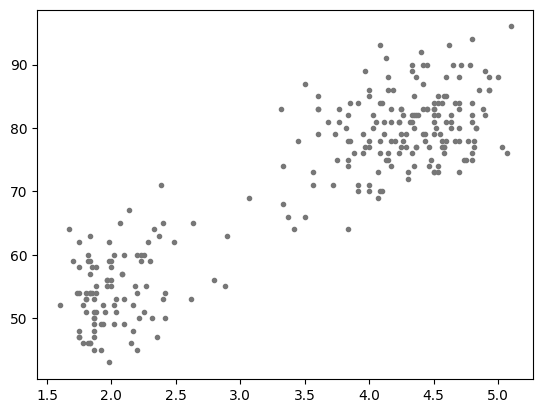

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def loadOF():
    data = []
    with open("old-faithful.txt", "r") as f:
        lines = f.readlines()[1:]
        for line in lines:
            line_tokens = line.split()
            data.append([float(line_tokens[1]), int(line_tokens[2])])
    
    return data
        
old_faithful = np.array(loadOF())

plt.scatter(old_faithful[:,0], old_faithful[:,1], color="#777", marker=".")

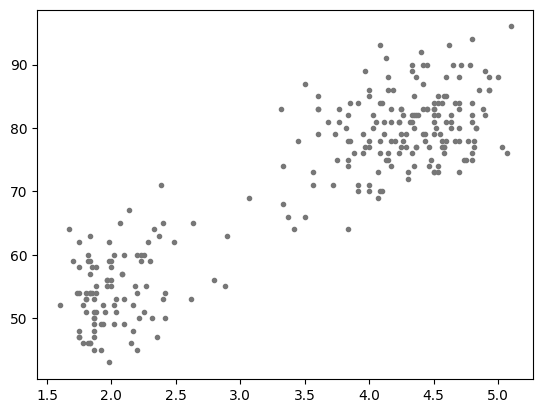

In [19]:
def visualize_data_model(dataset, params=None):
    """
    Computes a visualization of the model over the data
    
    Args:
        dataset (np.array): The dataset whose density is being estimated
        params (dict): A dictionary containing 'mus', 'covs', and 'pis', 
            the mixture components. If not passed in, will only plot the
            dataset.
    """
    df = pd.DataFrame(dataset)
    stats = df.describe()
    
    x_min, x_max = stats[0]["min"], stats[0]["max"]
    y_min, y_max = stats[1]["min"], stats[1]["max"]
    
    if params is not None:
        mus = params["mus"]
        covs = params["covs"]
        pis = params["pis"]
    
        # Plot model
        fig, ax = plot_mixture_model(mus, covs, pis, [x_min, x_max], [y_min, y_max])
    else:
        fig, ax = plt.subplots()
    
    # Plot data
    ax.scatter(dataset[:,0], dataset[:,1], color="#777", marker=".")

def plot_mixture_model(mus, covs, pis, x_lims, y_lims):
    x = np.linspace(x_lims[0], x_lims[1], 300)
    y = np.linspace(y_lims[0], y_lims[1], 300)
    X,Y = np.meshgrid(x,y)
    XY = np.stack((X,Y), axis=-1)
    XY = np.expand_dims(XY, axis=-1)

    fig, ax = plt.subplots()
    for mu, cov, pi in zip(mus, covs, pis):
        mu = np.array(mu).reshape((len(mu),1))
        cov = np.array(cov)
        det_cov = np.linalg.det(cov)
        cov_inv = np.linalg.inv(cov)
        Z = pi*(2*np.pi)**(-1)*(det_cov)**(-1/2)*np.exp(-(1/2)*np.transpose((XY-mu), (0,1,3,2))@cov_inv@(XY-mu))
        Z = np.squeeze(Z)
        mvg_plot = ax.contour(X,Y,Z)
    
    return fig, ax

# mu needs to be a vector not a sequence
visualize_data_model(old_faithful)

### Implementation

We will start by initializing our parameters and then proceed to run the EM algorithm.

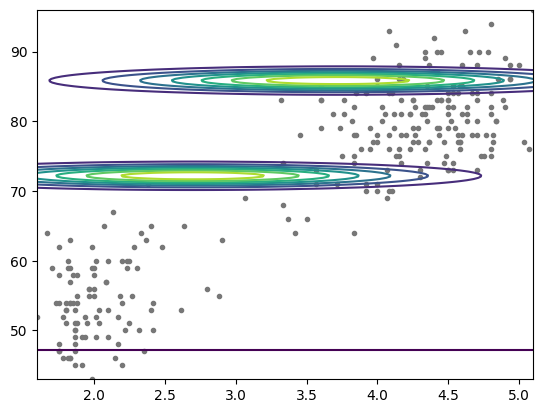

In [22]:
def initialize_params(k, dataset):
    """
    Initialize GMM parameters.
    
    Args:
        k (int): A hyperparameter; the number of mixture components that the
            model specifies.
    
    Returns:
        dict: GMM parameters
    """
    df = pd.DataFrame(dataset)
    stats = df.describe()
    
    x_min, x_max = stats[0]["min"], stats[0]["max"]
    y_min, y_max = stats[1]["min"], stats[1]["max"]
    
    x_sample = np.random.uniform(x_min, x_max, k)
    y_sample = np.random.uniform(y_min, y_max, k)
    
    mus = [[x_sample[i], y_sample[i]] for i in range(k)]
    covs = [[[1,0],[0,1]] for i in range(k)]
    pis = [1./k for i in range(k)]
    
    return {
        "mus": mus,
        "covs": covs,
        "pis": pis
    }

def E_step(params, dataset):
    pass

def M_step(params, dataset, responsibilities):
    pass

# Define hyperparameter k and initialize parameters
k = 2
params = initialize_params(2, old_faithful)

# Run the iterative ML Estimation
num_iterations = 1
for i in range(num_iterations):
    responsibilities = E_step(params, old_faithful)
    params = M_step(params, old_faithful, responsibilities)
    
visualize_data_model(old_faithful, params)